# Uniform sampling of orientation space

This notebook shows how to uniformly sample orientation space SO(3) of crystallographic proper point groups. The proper point groups given in the two widely used notations of Hermann-Mauguin and Schoenflies are

Hermann-Mauguin	Schoenflies
1	C1
2	C2
222	D2
4	C4
422	D4
3	C3
32	D3
6	C6
622	D6
23	T
432	O
We can sample either the entire orientation space with orix.sampling.get_sample_fundamental() or around a certain orientation with orix.sampling.get_sample_local(). Both functions accept a resolution  parameter, which is the average disorientation (smallest misorientation) between sampled orientations. get_sample_fundamental() also accepts a proper point group specifier, either by passing the point_group or space_group, from which the proper point group will be determined (for example space group 225 
 -> point group 
 -> proper point group 432). This ensures that the returned orientations are within the point group's fundamental zone.

Three sampling methods are available, and their names accepted as strings to the method parameter in the two functions are:

"cubochoric"
"haar_euler"
"quaternion"
The cubochoric sampling method is presented in Singh and De Graef (2016) and Rosca et al. (2014). The starting point of the method is a uniform sampling of a cube. The number of semi-edge steps of this cube  is determined either from resolution  by the empirical expression

 
or it can be passed directly to the two functions in the semi_edge_steps parameter when method="cubochoric". As an example, for the cubic point group 432,  = 100 will result in 333 227 uniformly sampled orientations on SO(3), with . After the cube is sampled, these coordinates are projected onto SO(3) as explained in the above two references. The sample contains the identity rotation. The implementation in orix should produce identical results to the one from EMsoft's command line program EMsampleRFZ, which the implementation is based upon.

The sample from the Haar Euler method is proportional to , and explained further on Stack Overflow.

The quaternion sampling method is implemented as described in La Valle (2006).

In [86]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from orix.io import save
from orix.quaternion import Orientation, symmetry
from orix.sampling import get_sample_fundamental
from orix.vector import Vector3d


plt.rcParams.update({
    "axes.grid": True,
    "figure.figsize": (15, 5),
    "font.size": 20,
    "lines.linewidth": 2,
})

## Sample

Let's first generate sampled orientations for the point group 432 with an average disorientation of 2deg

In [87]:
pg422 = symmetry.D4
resolution2 = 3

In [88]:
rot_cube = get_sample_fundamental(resolution2, point_group=pg422, method="cubochoric")
#rot_cube = get_sample_fundamental(point_group=pg422, method="cubochoric", semi_edge_steps=67)  # Gives identical results
rot_cube

Rotation (90979,)
[[ 0.6699 -0.6001 -0.339  -0.2759]
 [ 0.6699 -0.6001 -0.339   0.2759]
 [ 0.6699 -0.6114 -0.3182 -0.276 ]
 ...
 [ 0.6699  0.6114  0.3182  0.276 ]
 [ 0.6699  0.6001  0.339  -0.2759]
 [ 0.6699  0.6001  0.339   0.2759]]

In [89]:
ori_cube = Orientation(rot_cube, symmetry=pg422)
#ori_cube.data
#save(filename="orientations_pg422_3_cubo.hdf5", object2write=ori_cube)
np.savetxt('orientations_pg422_3_cubo.csv', ori_cube.data, delimiter=",")
#print(isinstance(ori_cube, object))

In [90]:
rot_euler = get_sample_fundamental(resolution2, point_group=pg422, method="haar_euler")
ori_euler = Orientation(rot_euler, symmetry=pg422)
np.savetxt('orientations_pg422_3_euler.csv', ori_euler.data, delimiter=",")
print(ori_euler.size)

109807


In [91]:
rot_quat = get_sample_fundamental(resolution2, point_group=pg422, method="quaternion")
ori_quat = Orientation(rot_quat, symmetry=pg422)
np.savetxt('orientations_pg422_3_quat.csv', ori_quat.data, delimiter=",")
print(ori_quat.size)

106580


## Visualize Samples

We will only check the uniformity of these methods' sampling of the Rodrigues Fundamental Zone (RFZ) qualitatively here.

Let's draw a random sample of 10 000 orientations from each full sample and plot them within the RFZ, with a view from the top and the side

In [92]:
np.random.seed(42)  # For reproducibility of the random sample
n = 10000
ori_cube2 = ori_cube.get_random_sample(n)
ori_euler2 = ori_euler.get_random_sample(n)
ori_quat2 = ori_quat.get_random_sample(n)

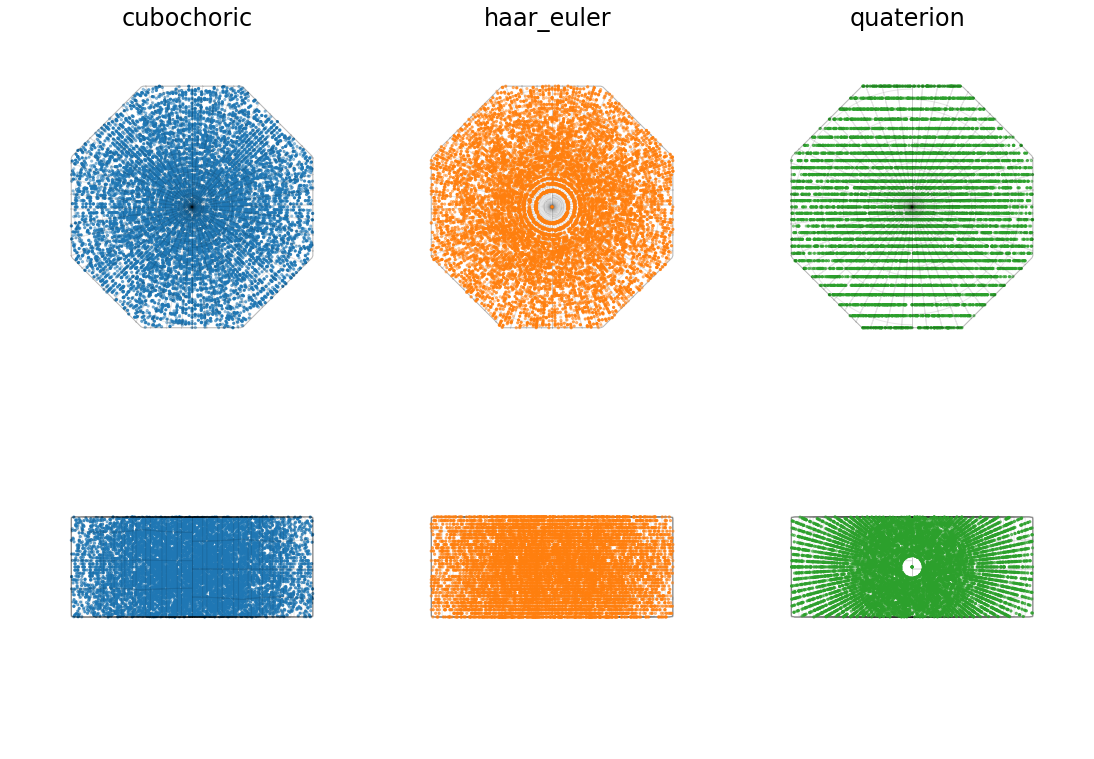

In [93]:
fig = plt.figure(figsize=(15, 10))
scatter_kwargs = dict(
    projection="rodrigues",
    figure=fig,
    wireframe_kwargs=dict(color="k", linewidth=1, alpha=0.1),
    s=5,
)

ori_cube2.scatter(position=231, c="C0", **scatter_kwargs)
ori_euler2.scatter(position=232, c="C1", **scatter_kwargs)
ori_quat2.scatter(position=233, c="C2", **scatter_kwargs)

ori_cube2.scatter(position=234, c="C0", **scatter_kwargs)
ori_euler2.scatter(position=235, c="C1", **scatter_kwargs)
ori_quat2.scatter(position=236, c="C2", **scatter_kwargs)

titles = ["cubochoric", "haar_euler", "quaterion"]
for i, title in zip([0, 1, 2], titles):
    fig.axes[i].view_init(elev=90, azim=0)
    fig.axes[i].set_title(titles[i])
for i in [3, 4, 5]:
    fig.axes[i].view_init(elev=0, azim=0)

Let's also plot the orientations' crystal directions in the x, y, and z sample directions in the inverse pole figure, per distribution

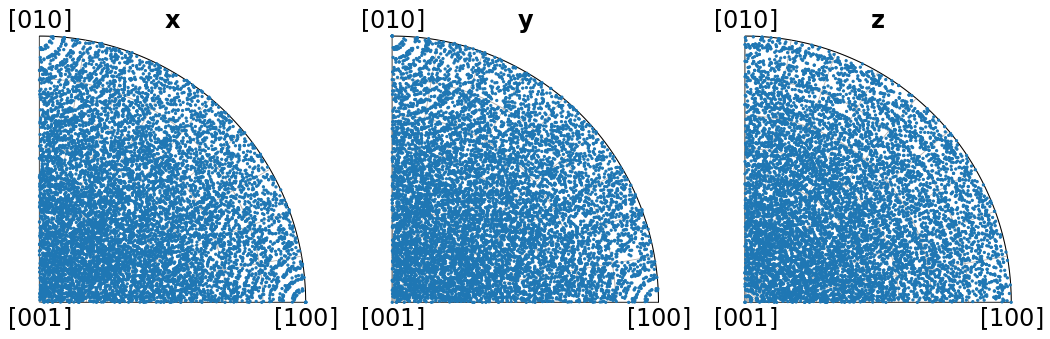

In [94]:
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))

ori_cube2.scatter("ipf", direction=directions, c="C0", s=5)

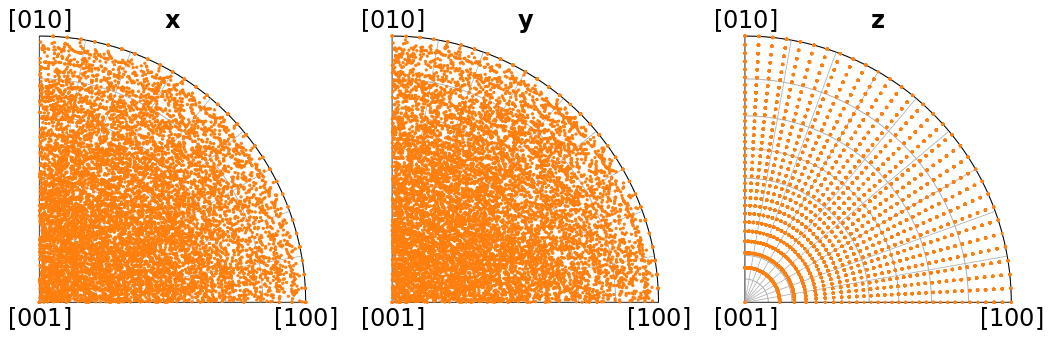

In [95]:
ori_euler2.scatter("ipf", direction=directions, c="C1", s=5)

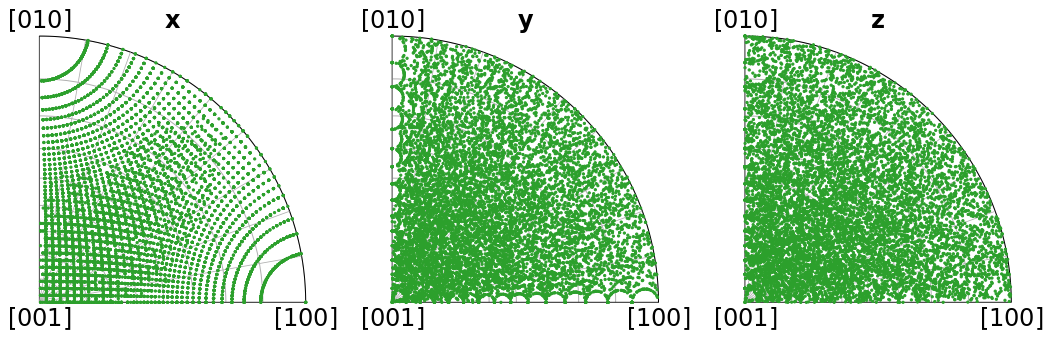

In [96]:
ori_quat2.scatter("ipf", direction=directions, c="C2", s=5)